In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 1024
LR = 1e-3
EPOCHS = 20
DATASET = 'MNIST'

print(f"Running on {device}")

Running on cuda


In [46]:
# ==========================================
# 2. Model Architecture (FIXED: NO DEADLOCK)
# ==========================================

class Squeeze(nn.Module):
    def forward(self, x, invert=False):
        B, C, H, W = x.shape
        if not invert:
            x = x.view(B, C, H//2, 2, W//2, 2)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(B, C*4, H//2, W//2)
            return x
        else:
            x = x.view(B, C//4, 2, 2, H, W)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(B, C//4, H*2, W*2)
            return x

class Split(nn.Module):
    def forward(self, x):
        x, z = x.chunk(2, dim=1)
        return x, z

    def inverse(self, x, z):
        return torch.cat([x, z], dim=1)

class ResNetSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, out_channels, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

class CouplingLayer(nn.Module):
    def __init__(self, channels, mask_type='checkerboard', reverse=False):
        super().__init__()
        self.mask_type = mask_type
        self.reverse = reverse
        self.net = ResNetSimple(channels, channels * 2)

    def get_mask(self, x):
        B, C, H, W = x.shape
        if self.mask_type == 'checkerboard':
            mask = torch.from_numpy(
                ((np.indices((H, W)).sum(axis=0) % 2) == 0)
            ).float().to(x.device)
            if self.reverse:
                mask = 1 - mask
            return mask.view(1, 1, H, W)
        else:
            mask = torch.zeros_like(x)
            mask[:, :C//2] = 1
            if self.reverse:
                mask = 1 - mask
            return mask

    def forward(self, x, invert=False):
        mask = self.get_mask(x)
        x_masked = x * mask

        s, t = self.net(x_masked).chunk(2, dim=1)
        s = 0.8 * torch.tanh(s)   # STABLE scaling

        if not invert:
            y = x * torch.exp(s * (1 - mask)) + t * (1 - mask)
            log_det = (s * (1 - mask)).sum(dim=[1,2,3])
            return y, log_det
        else:
            y = (x - t * (1 - mask)) * torch.exp(-s * (1 - mask))
            return y

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # Scale 1 (28×28)
        self.c1 = CouplingLayer(1, 'checkerboard')
        self.c2 = CouplingLayer(1, 'checkerboard', reverse=True)

        # Downscale
        self.squeeze = Squeeze()
        self.split = Split()

        # Scale 2 (14×14)
        self.c3 = CouplingLayer(2, 'channel')
        self.c4 = CouplingLayer(2, 'channel', reverse=True)
        self.c5 = CouplingLayer(2, 'channel')

    def forward(self, x):
        log_det = 0

        # Scale 1
        x, ld = self.c1(x); log_det += ld
        x, ld = self.c2(x); log_det += ld

        # Downscale + split
        x = self.squeeze(x)
        x, z1 = self.split(x)

        # Scale 2
        x, ld = self.c3(x); log_det += ld
        x, ld = self.c4(x); log_det += ld
        x, ld = self.c5(x); log_det += ld

        # x is z2
        return (x, z1), log_det

    def inverse(self, z):
        z2, z1 = z

        # Reverse scale 2
        x = self.c5(z2, invert=True)
        x = self.c4(x, invert=True)
        x = self.c3(x, invert=True)

        # Merge + upscale
        x = self.split.inverse(x, z1)
        x = self.squeeze(x, invert=True)

        # Reverse scale 1
        x = self.c2(x, invert=True)
        x = self.c1(x, invert=True)

        return x

In [47]:
# ==========================================
# 3. Helpers & Loss
# ==========================================

def get_loss(model, x):
    (z2, z1), log_det = model(x)

    z = torch.cat([z2, z1], dim=1)
    prior = -0.5 * (z**2 + np.log(2*np.pi))
    prior = prior.sum(dim=[1,2,3])

    return -(prior + log_det).mean()

# ==========================================
# 4. Data Loading
# ==========================================

class Dequantize(object):
    def __call__(self, x):
        return x + torch.rand_like(x) / 256

transform = transforms.Compose([
    transforms.ToTensor(),
    Dequantize()
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


In [48]:
model = RealNVP().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = get_loss(model, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            val_loss += get_loss(model, x).item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train {train_loss:.2f} | Val {val_loss:.2f}")


Epoch 1: Train -71.14 | Val -234.24
Epoch 2: Train -249.00 | Val -265.57
Epoch 3: Train -279.49 | Val -291.28
Epoch 4: Train -298.34 | Val -304.70
Epoch 5: Train -167.21 | Val -263.19
Epoch 6: Train -287.81 | Val -299.14
Epoch 7: Train -302.59 | Val -305.55
Epoch 8: Train -307.28 | Val -309.13
Epoch 9: Train -310.35 | Val -311.85
Epoch 10: Train -312.83 | Val -314.17
Epoch 11: Train -315.05 | Val -316.34
Epoch 12: Train -317.09 | Val -318.29
Epoch 13: Train -318.96 | Val -320.12
Epoch 14: Train -320.73 | Val -321.86
Epoch 15: Train -322.44 | Val -323.51
Epoch 16: Train -324.06 | Val -325.12
Epoch 17: Train -325.60 | Val -326.62
Epoch 18: Train -327.03 | Val -327.93
Epoch 19: Train -328.35 | Val -329.23
Epoch 20: Train -329.60 | Val -330.49


Ateempt 1 (20 epochs, batch 64, MNIST)

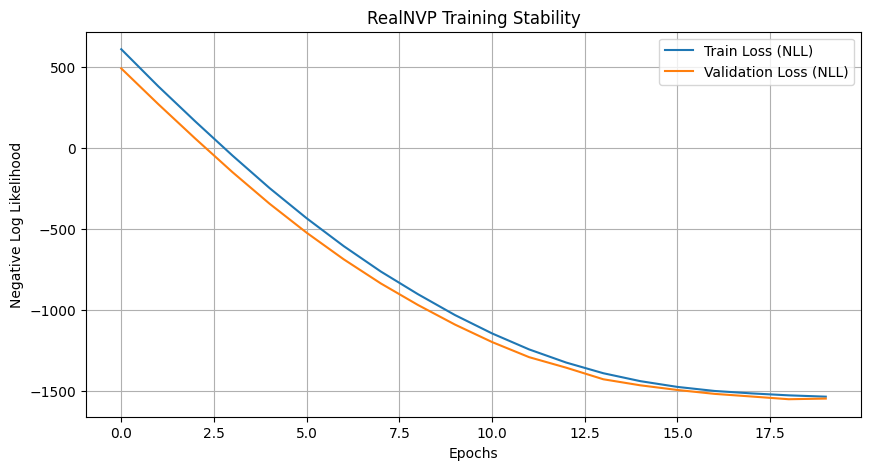

Generating samples...


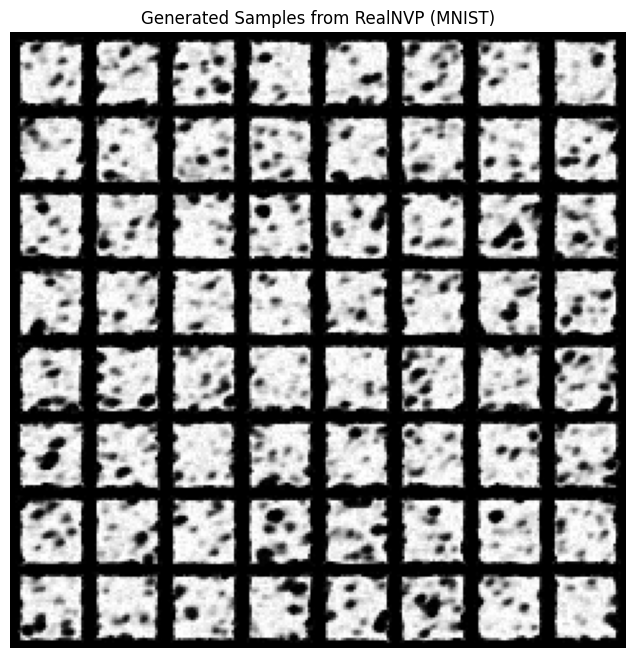

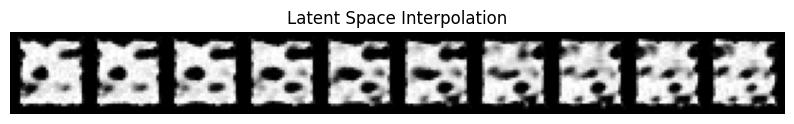

In [5]:
# ==========================================
# 6. Visualization & Evaluation
# ==========================================

# 1. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (NLL)')
plt.plot(test_losses, label='Validation Loss (NLL)')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.title('RealNVP Training Stability')
plt.legend()
plt.grid(True)
plt.show()

# 2. Generate Samples
print("Generating samples...")
model.eval()
generated_imgs = sample_images(model, n_samples=64)

# Plot Grid
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples from RealNVP ({DATASET})')
plt.show()

# 3. Latent Space Interpolation (Optional but cool for report)
def interpolate(model, n_steps=10):
    z1 = torch.randn(1, 1, 28, 28).to(device)
    z2 = torch.randn(1, 1, 28, 28).to(device)

    alphas = torch.linspace(0, 1, n_steps).to(device)
    interpolated_imgs = []

    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.inverse(z_interp)
            interpolated_imgs.append(x_interp.cpu())

    return torch.cat(interpolated_imgs)

interp_imgs = interpolate(model)
grid_interp = torchvision.utils.make_grid(interp_imgs, nrow=10, padding=2)
plt.figure(figsize=(10, 2))
plt.imshow(grid_interp.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title('Latent Space Interpolation')
plt.show()

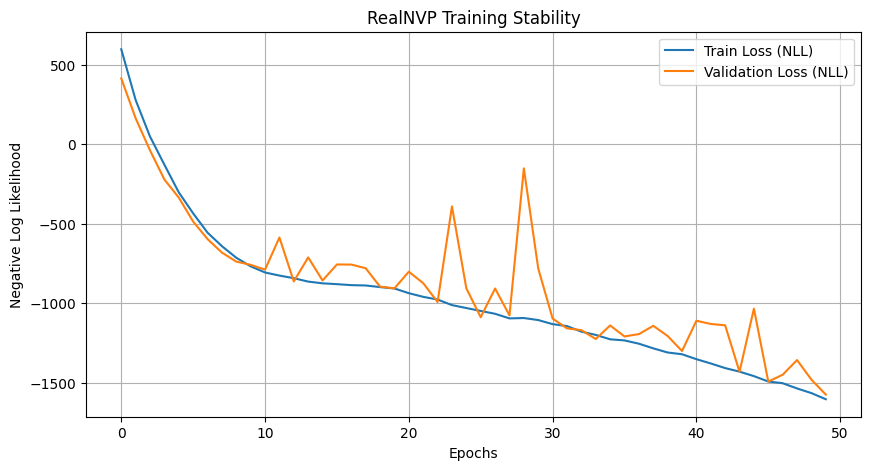

Generating samples...


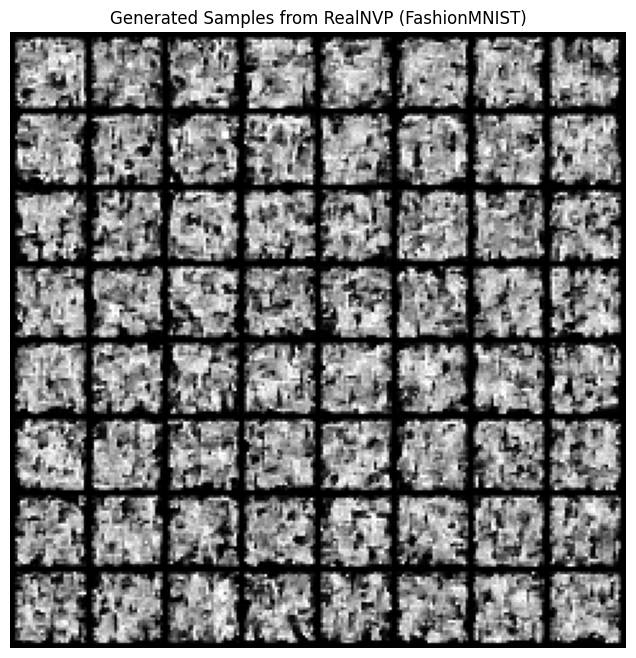

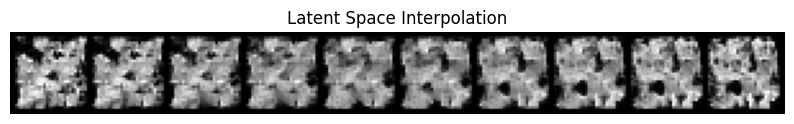

In [10]:
# ==========================================
# 6. Visualization & Evaluation
# ==========================================

# 1. Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (NLL)')
plt.plot(test_losses, label='Validation Loss (NLL)')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.title('RealNVP Training Stability')
plt.legend()
plt.grid(True)
plt.show()

# 2. Generate Samples
print("Generating samples...")
model.eval()
generated_imgs = sample_images(model, n_samples=64)

# Plot Grid
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples from RealNVP ({DATASET})')
plt.show()

# 3. Latent Space Interpolation (Optional but cool for report)
def interpolate(model, n_steps=10):
    z1 = torch.randn(1, 1, 28, 28).to(device)
    z2 = torch.randn(1, 1, 28, 28).to(device)

    alphas = torch.linspace(0, 1, n_steps).to(device)
    interpolated_imgs = []

    with torch.no_grad():
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.inverse(z_interp)
            interpolated_imgs.append(x_interp.cpu())

    return torch.cat(interpolated_imgs)

interp_imgs = interpolate(model)
grid_interp = torchvision.utils.make_grid(interp_imgs, nrow=10, padding=2)
plt.figure(figsize=(10, 2))
plt.imshow(grid_interp.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title('Latent Space Interpolation')
plt.show()

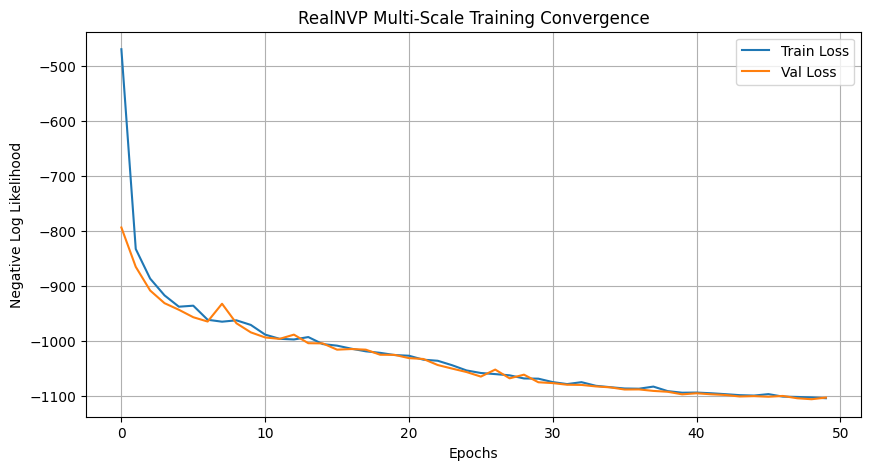

Generating samples from Multi-Scale model...


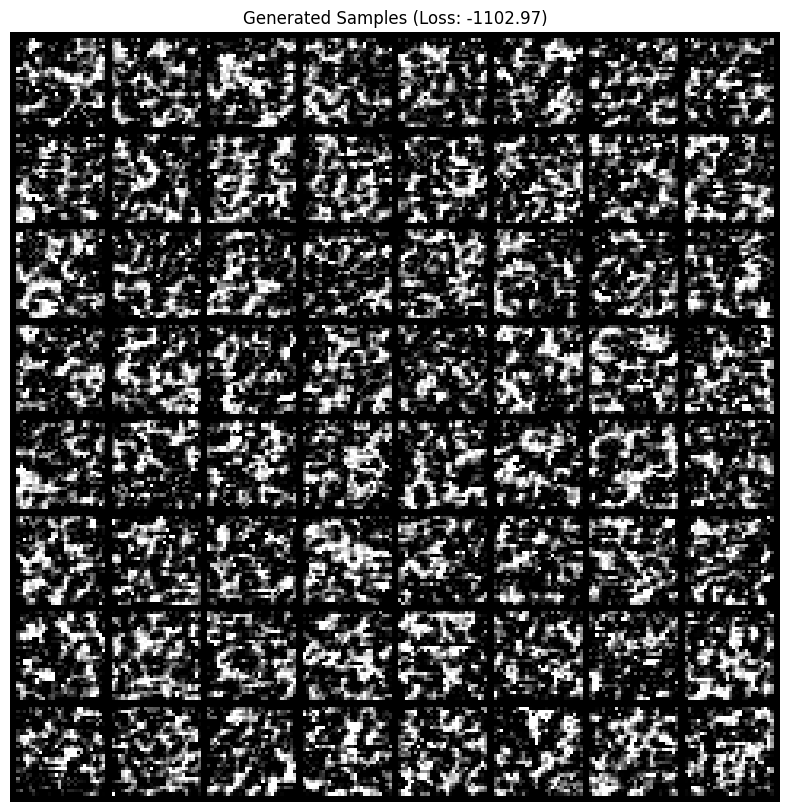

In [29]:
# ==========================================
# 6. Visualization (UPDATED for Multi-Scale)
# ==========================================

def sample_images(model, n_samples=64):
    model.eval()
    with torch.no_grad():
        # CRITICAL: The shape is now 4 channels, 14x14 spatial resolution
        z = torch.randn(n_samples, 4, 14, 14).to(device)

        # Invert the flow: z (noise) -> x (image)
        x_gen = model.inverse(z)

        # Clamp to valid image range [0, 1]
        x_gen = torch.clamp(x_gen, 0, 1)

    return x_gen.cpu()

# 1. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.title('RealNVP Multi-Scale Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

# 2. Show Samples
print("Generating samples from Multi-Scale model...")
generated_imgs = sample_images(model)

grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples (Loss: {test_losses[-1]:.2f})')
plt.show()

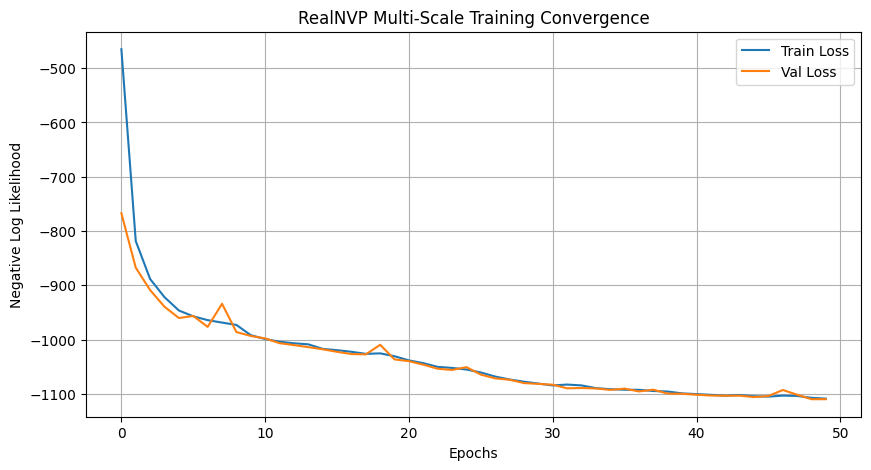

Generating samples from Multi-Scale model...


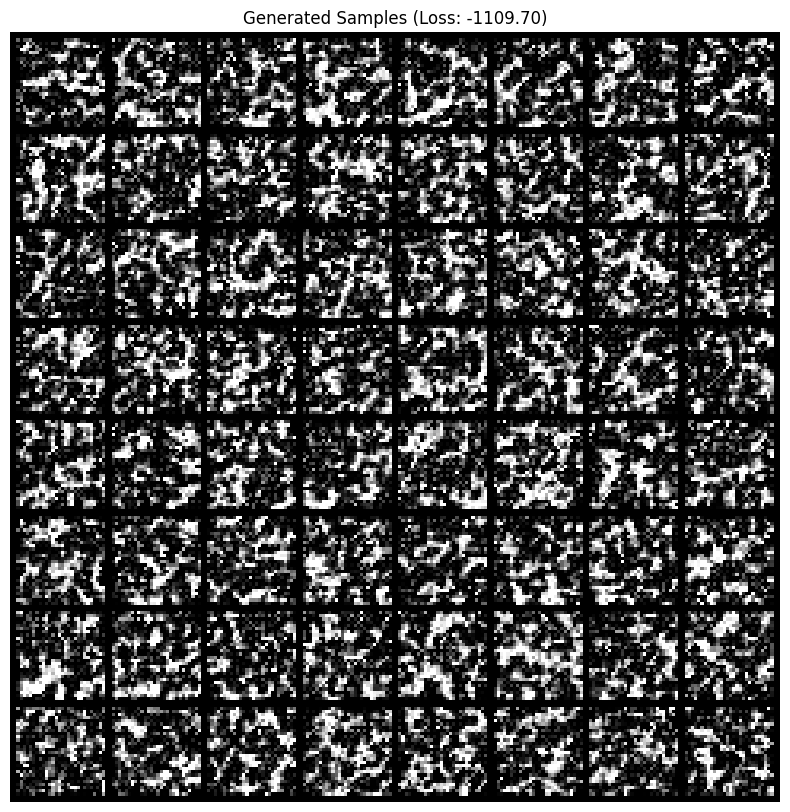

In [34]:
# ==========================================
# 6. Visualization (UPDATED for Multi-Scale)
# ==========================================

def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Coarse latent (structure)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.4

        # Fine latent (noise)
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.15

        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

# 1. Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.title('RealNVP Multi-Scale Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

# 2. Show Samples
print("Generating samples from Multi-Scale model...")
generated_imgs = sample_images(model)

grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Generated Samples (Loss: {test_losses[-1]:.2f})')
plt.show()

In [49]:
def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Coarse latent (structure)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.4

        # Fine latent (noise)
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.15

        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

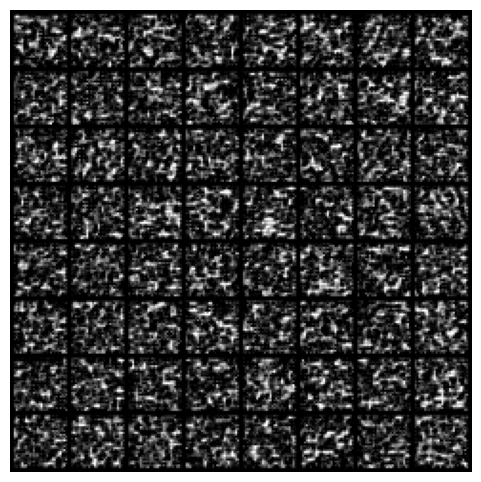

In [50]:
samples = sample_images(model)
grid = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64  # Smaller batch size often helps flows converge smoother
LR = 1e-4
EPOCHS = 20
DATASET = 'MNIST'

print(f"Running on {device}")

# ==========================================
# 2. Model Architecture (IMPROVED)
# ==========================================

class Squeeze(nn.Module):
    def forward(self, x, invert=False):
        B, C, H, W = x.shape
        if not invert:
            # Squeeze: (B, C, H, W) -> (B, 4*C, H/2, W/2)
            x = x.view(B, C, H//2, 2, W//2, 2)
            x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
            x = x.view(B, C*4, H//2, W//2)
            return x
        else:
            # Unsqueeze: (B, 4*C, H, W) -> (B, C, H*2, W*2)
            # We must explicitly infer output channels to avoid shape errors
            x = x.view(B, C//4, 2, 2, H, W)
            x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
            x = x.view(B, C//4, H*2, W*2)
            return x

class Split(nn.Module):
    def forward(self, x):
        # Splits the channel dimension in half
        x, z = x.chunk(2, dim=1)
        return x, z

    def inverse(self, x, z):
        # Concatenates back
        return torch.cat([x, z], dim=1)

class ResNetSimple(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # WIDER = Better Quality
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, out_channels, 3, padding=1)
        )
        # Zero Init (Critical)
        self.net[-1].weight.data.zero_()
        self.net[-1].bias.data.zero_()

    def forward(self, x):
        return self.net(x)


class CouplingLayer(nn.Module):
    def __init__(self, channels, mask_type='checkerboard', reverse=False):
        super().__init__()
        self.mask_type = mask_type
        self.reverse = reverse

        # Neural net to predict scale (s) and translation (t)
        self.net = ResNetSimple(channels, channels * 2)

        # Learnable scale parameter to help convergence
        self.scale = nn.Parameter(torch.ones(1))

    def get_mask(self, x):
        B, C, H, W = x.shape
        if self.mask_type == 'checkerboard':
            mask = ((np.indices((H, W)).sum(axis=0) % 2) == 0)
            mask = torch.from_numpy(mask).float().to(x.device).view(1, 1, H, W)
        else:
            mask = torch.zeros((1, C, 1, 1), device=x.device)
            mask[:, :C//2, :, :] = 1

        if self.reverse:
            mask = 1 - mask
        return mask

    def forward(self, x, invert=False):
        mask = self.get_mask(x)
        x_masked = x * mask

        s_t = self.net(x_masked)
        s, t = s_t.chunk(2, dim=1)

        # STABILIZATION FIX: Tanh * scale
        # This prevents 's' from ever being too large, preventing exp(s) explosion
        s = torch.tanh(s) * self.scale

        if not invert:
            # y = x * exp(s) + t
            y = x * torch.exp(s * (1 - mask)) + t * (1 - mask)
            log_det = (s * (1 - mask)).sum(dim=[1, 2, 3])
            return y, log_det
        else:
            # x = (y - t) * exp(-s)
            y = (x - t * (1 - mask)) * torch.exp(-s * (1 - mask))
            return y

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        # Deeper flow (3 layers per scale) is a sweet spot for stability vs quality
        self.scale1 = nn.ModuleList([
            CouplingLayer(1, 'checkerboard', reverse=False),
            CouplingLayer(1, 'checkerboard', reverse=True),
            CouplingLayer(1, 'checkerboard', reverse=False)
        ])

        self.squeeze = Squeeze() # Uses the Squeeze class you already have
        self.split = Split()     # Uses the Split class you already have

        self.scale2 = nn.ModuleList([
            CouplingLayer(2, 'channel', reverse=False),
            CouplingLayer(2, 'channel', reverse=True),
            CouplingLayer(2, 'channel', reverse=False)
        ])

    def forward(self, x):
        log_det = 0

        for layer in self.scale1:
            x, ld = layer(x)
            log_det += ld

        x = self.squeeze(x)
        x, z1 = self.split(x)

        for layer in self.scale2:
            x, ld = layer(x)
            log_det += ld

        return (x, z1), log_det

    def inverse(self, z):
        z2, z1 = z
        x = z2

        for layer in reversed(self.scale2):
            x = layer(x, invert=True)

        x = self.split.inverse(x, z1)
        x = self.squeeze(x, invert=True)

        for layer in reversed(self.scale1):
            x = layer(x, invert=True)

        return x

# ==========================================
# 3. Helpers & Loss
# ==========================================

def get_loss(model, x):
    (z2, z1), log_det = model(x)

    # Calculate Gaussian NLL
    z = torch.cat([z2, z1], dim=1)

    # Standard Normal Prior NLL: 0.5 * (z^2 + log(2pi))
    prior_nll = 0.5 * (z**2 + np.log(2 * np.pi))
    prior_nll = prior_nll.sum(dim=[1,2,3])

    # NLL = Prior_NLL - Log_Det
    loss = prior_nll - log_det
    return loss.mean()

# ==========================================
# 4. Data & Training
# ==========================================

class Dequantize(object):
    def __call__(self, x):
        # Convert discrete [0, 255] to continuous [0, 1]
        return x + torch.rand_like(x) / 256.0

transform = transforms.Compose([
    transforms.ToTensor(), # Output is [0, 1]
    Dequantize()
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

# Increased batch size slightly for stable BN statistics
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=True)

model = RealNVP().to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = get_loss(model, x)
        loss.backward()

        # Gradient clipping prevents explosion in early epochs
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}")

# ==========================================
# 5. Visualization
# ==========================================

def sample_images(model, n=64):
    model.eval()
    with torch.no_grad():
        # Multiply by 0.6 to reduce variance (Temperature Sampling)
        z1 = torch.randn(n, 2, 14, 14).to(device) * 0.6
        z2 = torch.randn(n, 2, 14, 14).to(device) * 0.6

        # Invert
        x = model.inverse((z2, z1))
        x = torch.clamp(x, 0, 1)
    return x.cpu()

samples = sample_images(model)
grid = torchvision.utils.make_grid(samples, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0), cmap='gray')
plt.axis('off')
plt.title("Generated Samples")
plt.show()

Running on cuda
Starting training...
Epoch 1: Train Loss -893.9292
Epoch 2: Train Loss -1066.1578
Epoch 3: Train Loss -1184.5814
Epoch 4: Train Loss -1289.5768
Epoch 5: Train Loss -1385.2436
Epoch 6: Train Loss -1470.4845
Epoch 7: Train Loss -1548.2375
Epoch 8: Train Loss -1623.1479
Epoch 9: Train Loss -1691.5648
Epoch 10: Train Loss -1755.2543
Epoch 11: Train Loss -1806.9843
Epoch 12: Train Loss -1862.7742
Epoch 13: Train Loss -1914.8003
Epoch 14: Train Loss -1971.7264


Using device: cuda
>>> 1. Running Autoencoder Experiments


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


Training Autoencoder with Latent Dim: 2
Training Autoencoder with Latent Dim: 16
Training Autoencoder with Latent Dim: 64


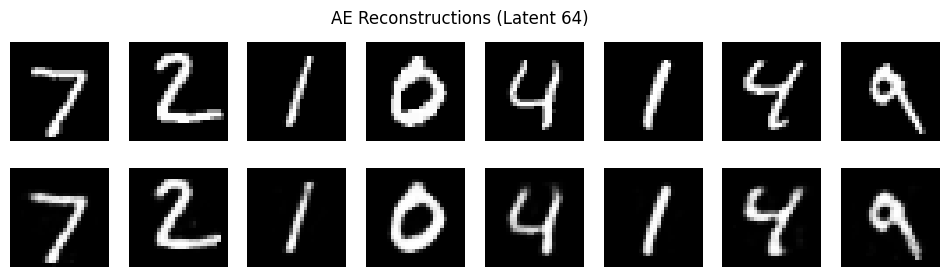

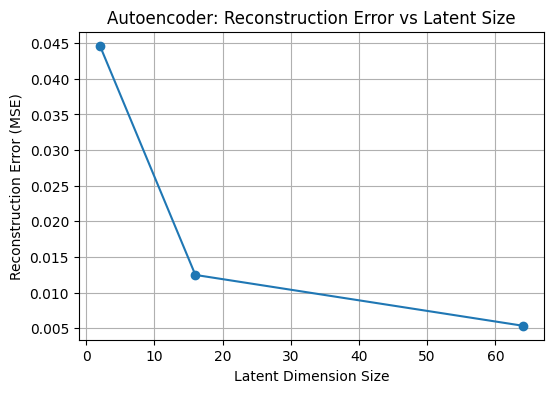


>>> 2. Running VAE on MNIST Digits
--- Training VAE on MNIST (Beta=1.0) ---
Epoch 5: Average Loss: 109.6529
Epoch 10: Average Loss: 106.0604
Epoch 15: Average Loss: 104.6916
Epoch 20: Average Loss: 103.8857


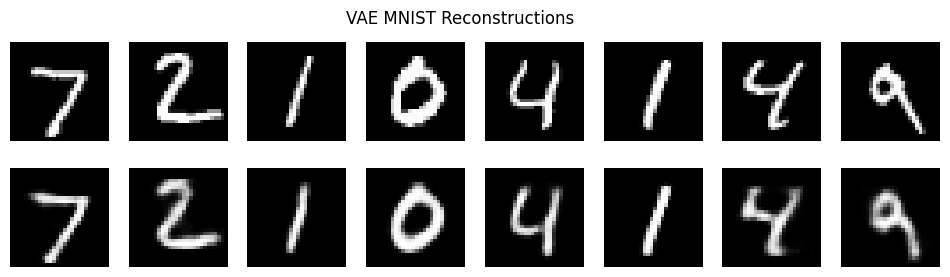

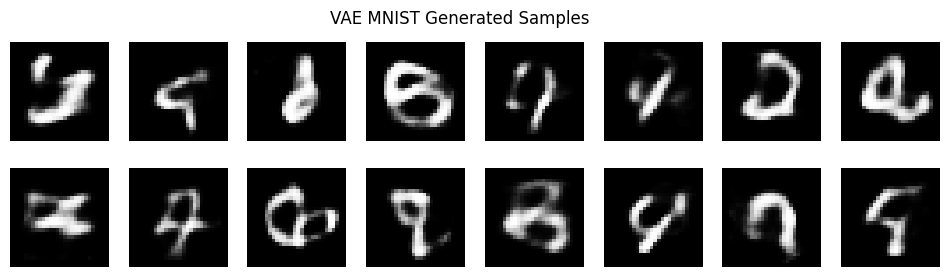


>>> 3. Running VAE on Fashion-MNIST


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]


--- Training VAE on FashionMNIST (Beta=1.0) ---
Epoch 5: Average Loss: 245.9414
Epoch 10: Average Loss: 242.5460
Epoch 15: Average Loss: 241.1294
Epoch 20: Average Loss: 240.3023


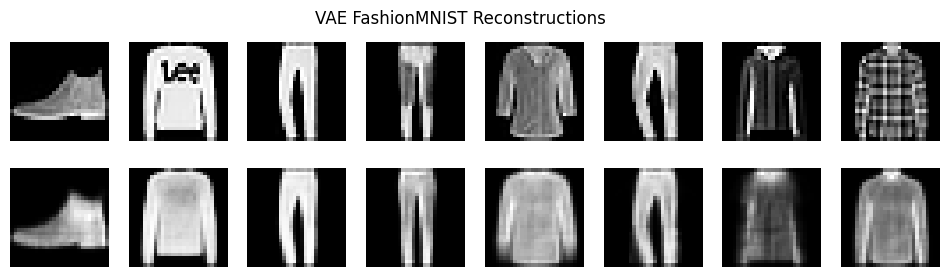

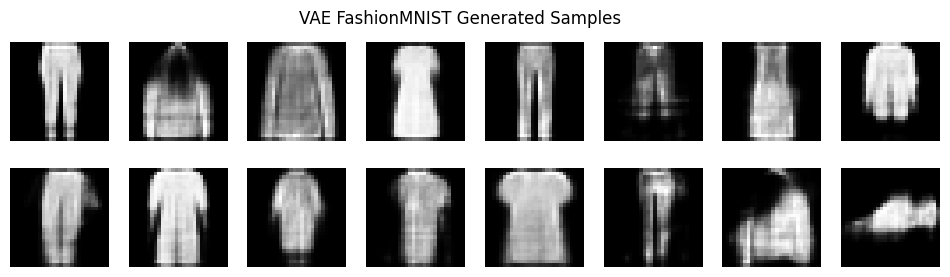


>>> 4. Running f-VAE (RealNVP)
--- Training f-VAE (VAE + RealNVP) ---
Epoch 5: Loss: 109.7315
Epoch 10: Loss: 105.8822
Epoch 15: Loss: 104.3177
Epoch 20: Loss: 103.3362


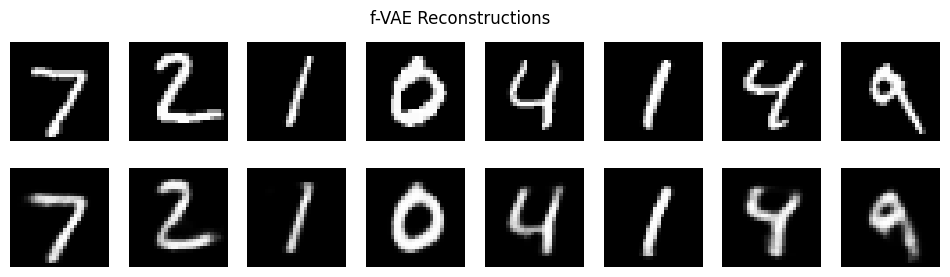

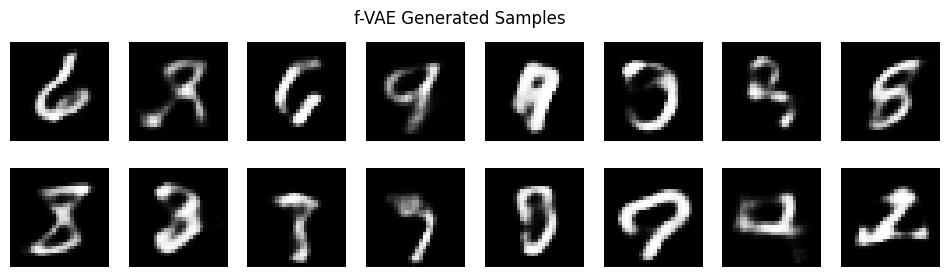


>>> 5. Running Beta-VAE Exploration (Bonus)
--- Training VAE on MNIST (Beta=4.0) ---
Epoch 5: Average Loss: 152.8630
Epoch 10: Average Loss: 149.8845
Epoch 15: Average Loss: 148.4024
Epoch 20: Average Loss: 147.3844


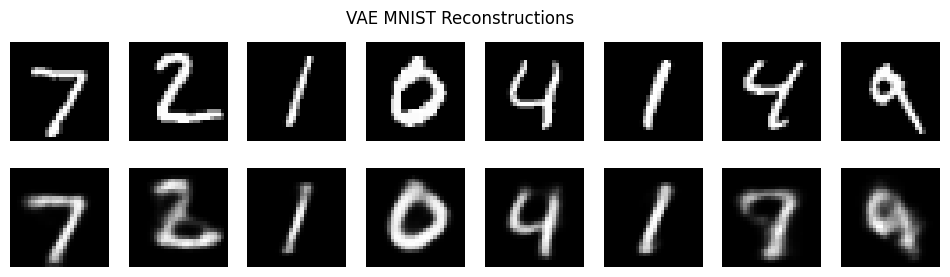

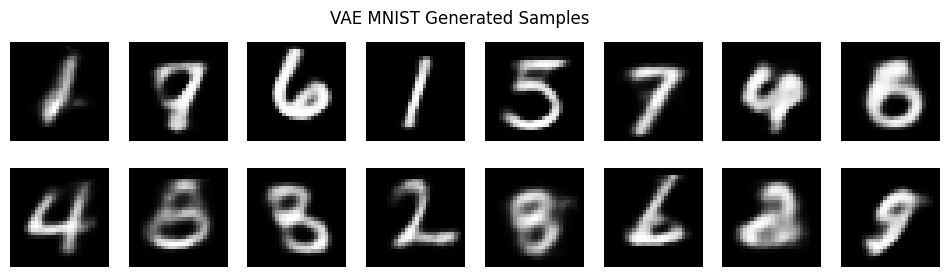

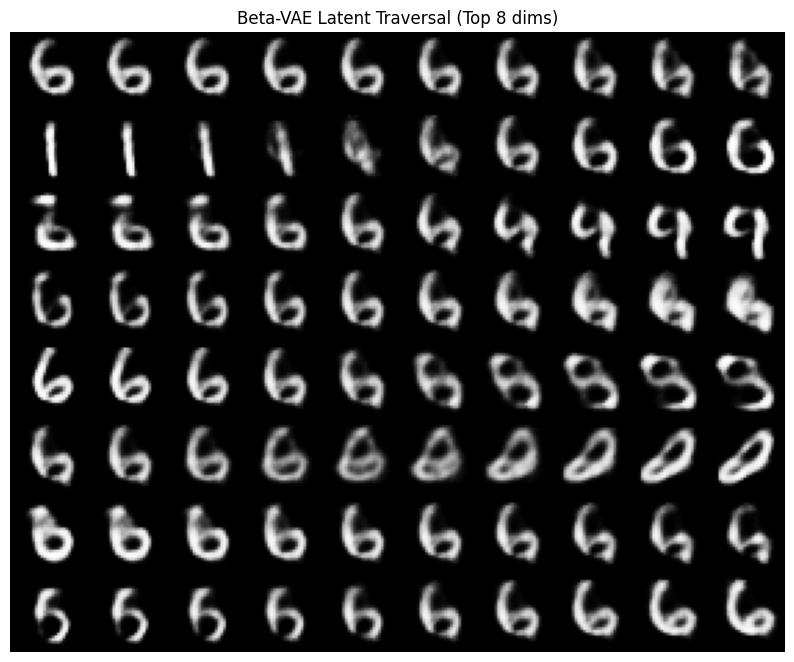

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import copy

# ==========================================
# 1. CONFIGURATION & HELPERS
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCHS = 20  # Reduced for homework demonstration; increase for better results

print(f"Using device: {DEVICE}")

def get_dataloaders(dataset_name='MNIST'):
    transform = transforms.Compose([transforms.ToTensor()])
    if dataset_name == 'MNIST':
        train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == 'FashionMNIST':
        train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    return (DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True),
            DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False))

def plot_reconstructions(model, dataloader, title="Reconstructions"):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:8].to(DEVICE)

    with torch.no_grad():
        if isinstance(model, FVAE):
            # FVAE returns 6 items, we only need the first one (recon)
            # We use *args to safely ignore the remaining 5 return values
            recon, *args = model(images)
        elif isinstance(model, VAE):
            recon, _, _ = model(images)
        else: # Autoencoder
            recon = model(images)

    images = images.cpu().numpy()
    recon = recon.cpu().numpy()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    fig.suptitle(title)
    for i in range(8):
        # Original Image
        axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed Image
        axes[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# ==========================================
# 2. AUTOENCODER (Task 1)
# ==========================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=32):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, input_dim),
            nn.Sigmoid() # Output pixels 0-1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon.view(x.size(0), 1, 28, 28)

def train_ae(latent_dims):
    train_loader, test_loader = get_dataloaders('MNIST')
    results = {}

    for ld in latent_dims:
        print(f"Training Autoencoder with Latent Dim: {ld}")
        model = Autoencoder(latent_dim=ld).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()

        final_loss = 0
        for epoch in range(5): # Short training for experiment
            model.train()
            total_loss = 0
            for imgs, _ in train_loader:
                imgs = imgs.to(DEVICE)
                optimizer.zero_grad()
                recon = model(imgs)
                loss = criterion(recon, imgs)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            final_loss = total_loss / len(train_loader)

        results[ld] = final_loss
        if ld == latent_dims[-1]: # Plot for the last one
            plot_reconstructions(model, test_loader, title=f"AE Reconstructions (Latent {ld})")

    # Plot Error vs Latent Size
    plt.figure(figsize=(6, 4))
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel('Latent Dimension Size')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Autoencoder: Reconstruction Error vs Latent Size')
    plt.grid(True)
    plt.show()

# ==========================================
# 3. VARIATIONAL AUTOENCODER (Task 2 & Bonus Beta-VAE)
# ==========================================
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon.view(x.size(0), 1, 28, 28), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # BCE = Reconstruction Loss
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # KLD = KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + (beta * KLD)

def train_vae(dataset_name='MNIST', beta=1.0, latent_dim=20, epochs=EPOCHS):
    train_loader, test_loader = get_dataloaders(dataset_name)
    model = VAE(latent_dim=latent_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print(f"--- Training VAE on {dataset_name} (Beta={beta}) ---")
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss_function(recon_batch, data, mu, logvar, beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Average Loss: {train_loss / len(train_loader.dataset):.4f}')

    # Visualize Reconstructions
    plot_reconstructions(model, test_loader, title=f"VAE {dataset_name} Reconstructions")

    # Visualize Generated Samples
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(DEVICE)
        sample = model.decode(z).cpu()
        fig, axes = plt.subplots(2, 8, figsize=(12, 3))
        fig.suptitle(f"VAE {dataset_name} Generated Samples")
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(sample[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

    return model

# Function for Beta-VAE Traversal (Bonus)
def visualize_latent_traversal(model, latent_dim=20):
    # Traverse one dimension at a time while keeping others fixed
    model.eval()
    n_traversals = 10
    limit = 3
    grid_x = torch.linspace(-limit, limit, n_traversals)

    # Create a base latent vector
    z_base = torch.randn(1, latent_dim).to(DEVICE)

    # We will traverse the first 8 dimensions
    dims_to_check = min(8, latent_dim)

    canvas = np.zeros((28 * dims_to_check, 28 * n_traversals))

    for i in range(dims_to_check):
        z = z_base.clone().repeat(n_traversals, 1)
        z[:, i] = grid_x.to(DEVICE)

        with torch.no_grad():
            generated = model.decode(z).cpu().view(-1, 28, 28).numpy()

        for j in range(n_traversals):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = generated[j]

    plt.figure(figsize=(10, 10))
    plt.title(f"Beta-VAE Latent Traversal (Top {dims_to_check} dims)")
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.show()

# ==========================================
# 4. f-VAE (RealNVP inside VAE) (Task 3)
# ==========================================
# A simple Affine Coupling Layer for RealNVP
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.mask = mask
        # Scale and Translation networks (s and t)
        self.s_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim), nn.Tanh()
        )
        self.t_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, z):
        # x_masked = z * mask
        z_masked = z * self.mask
        s = self.s_net(z_masked)
        t = self.t_net(z_masked)

        # y = z_masked + (1-mask) * (z * exp(s) + t)
        # Note: We only modify the masked-out parts
        z_out = z_masked + (1 - self.mask) * (z * torch.exp(s) + t)

        # Log Determinant of Jacobian: sum(log(scale)) for modified parts
        log_det_J = torch.sum((1 - self.mask) * s, dim=1)
        return z_out, log_det_J

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList()
        # Create alternating masks
        mask1 = torch.tensor([1 if i % 2 == 0 else 0 for i in range(input_dim)], dtype=torch.float32).to(DEVICE)
        mask2 = 1 - mask1

        # Add 4 coupling layers
        self.layers.append(CouplingLayer(input_dim, hidden_dim, mask1))
        self.layers.append(CouplingLayer(input_dim, hidden_dim, mask2))
        self.layers.append(CouplingLayer(input_dim, hidden_dim, mask1))
        self.layers.append(CouplingLayer(input_dim, hidden_dim, mask2))

    def forward(self, z):
        log_det_sum = 0
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_sum += log_det
        return z, log_det_sum

class FVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(FVAE, self).__init__()
        self.latent_dim = latent_dim
        # Standard VAE components
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # RealNVP Flow
        self.flow = RealNVP(latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # 1. Infer Initial Posterior q0(z0|x)
        mu, logvar = self.encode(x)
        z0 = self.reparameterize(mu, logvar)

        # 2. Apply Flow to get zk
        zk, log_det_J = self.flow(z0)

        # 3. Decode zk
        recon = self.decode(zk)

        return recon.view(x.size(0), 1, 28, 28), mu, logvar, z0, zk, log_det_J

def fvae_loss_function(recon_x, x, mu, logvar, z0, zk, log_det_J):
    # Reconstruction
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL Divergence with Flow:
    # KL = E[ log q(zk|x) - log p(zk) ]
    # log q(zk|x) = log q(z0|x) - sum(log_det_J)

    # 1. Log q(z0|x) (Gaussian entropy related)
    # log_q0 = -0.5 * (log(2*pi) + logvar + (z0-mu)^2/exp(logvar)) ... but simplified KLD trick is better:
    # We compute "Modified KLD" manually:

    # Log probability of z0 under q0 ~ N(mu, var)
    log_q0 = -0.5 * (torch.sum(logvar + (z0 - mu) ** 2 / torch.exp(logvar), dim=1))
    # Log probability of zk under Prior p(z) ~ N(0, I)
    log_pk = -0.5 * (torch.sum(zk ** 2, dim=1)) # ignoring consts like log(2pi) as they cancel or are constant

    # KL approx = log_q0 - log_det_J - log_pk
    # We use sum over batch
    kl_flow = torch.sum(log_q0 - log_det_J - log_pk)

    return BCE + kl_flow

def train_fvae():
    train_loader, test_loader = get_dataloaders('MNIST')
    model = FVAE(latent_dim=16).to(DEVICE) # latent 16 for stability
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training f-VAE (VAE + RealNVP) ---")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            recon, mu, logvar, z0, zk, log_det = model(data)
            loss = fvae_loss_function(recon, data, mu, logvar, z0, zk, log_det)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Loss: {train_loss / len(train_loader.dataset):.4f}')

    plot_reconstructions(model, test_loader, title="f-VAE Reconstructions")

    # Sampling from f-VAE
    # We sample from Prior N(0,I) and assume flow is invertible?
    # Usually in VAE-Flow, we learn q(z|x). Generating requires inverting the flow or just decoding N(0,I) if the flow forced z_k to be N(0,I).
    # However, here we optimized KL(q(zk)||p(z)), so zk should be close to N(0,I).
    # So we can sample z ~ N(0, I) and pass directly to decoder (approximate).
    with torch.no_grad():
        z = torch.randn(16, 16).to(DEVICE)
        sample = model.decode(z).cpu()
        fig, axes = plt.subplots(2, 8, figsize=(12, 3))
        fig.suptitle("f-VAE Generated Samples")
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(sample[i].view(28, 28), cmap='gray')
            ax.axis('off')
    plt.show()

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================
if __name__ == "__main__":
    print(">>> 1. Running Autoencoder Experiments")
    train_ae([2, 16, 64])

    print("\n>>> 2. Running VAE on MNIST Digits")
    vae_mnist = train_vae('MNIST', beta=1.0)

    print("\n>>> 3. Running VAE on Fashion-MNIST")
    vae_fashion = train_vae('FashionMNIST', beta=1.0)

    print("\n>>> 4. Running f-VAE (RealNVP)")
    train_fvae()

    print("\n>>> 5. Running Beta-VAE Exploration (Bonus)")
    # High Beta > 1 promotes disentanglement
    beta_vae = train_vae('MNIST', beta=4.0, latent_dim=10)
    visualize_latent_traversal(beta_vae, latent_dim=10)

Using device: cuda

--- Training Vanilla GAN on MNIST ---
Epoch 2/30 | D Loss: 0.0004 | G Loss: 10.4424


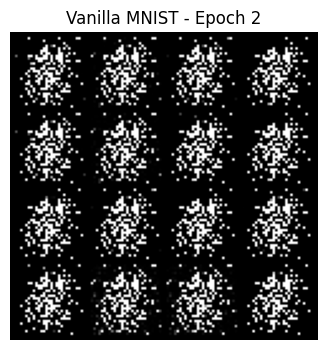

Epoch 4/30 | D Loss: 0.0000 | G Loss: 16.9025


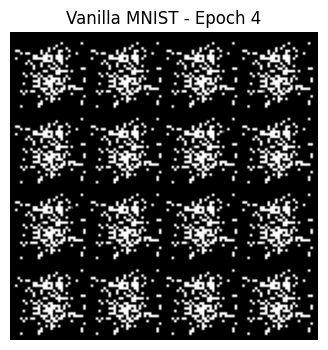

Epoch 6/30 | D Loss: 0.0000 | G Loss: 18.6337


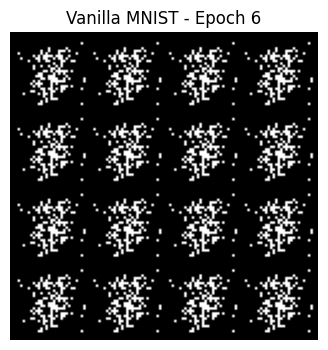

Epoch 8/30 | D Loss: 0.0000 | G Loss: 25.7355


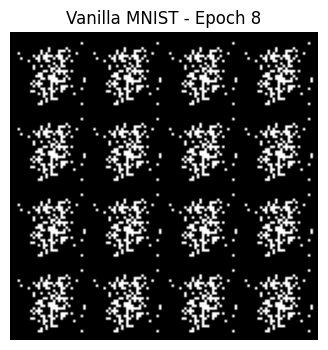

Epoch 10/30 | D Loss: 0.0000 | G Loss: 18.0490


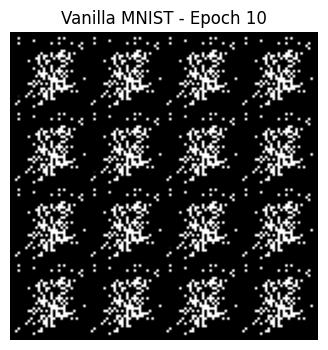

Epoch 12/30 | D Loss: 0.0000 | G Loss: 31.6925


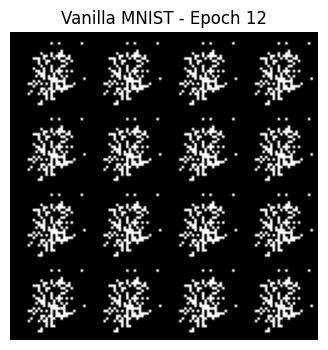

Epoch 14/30 | D Loss: 0.0000 | G Loss: 50.7100


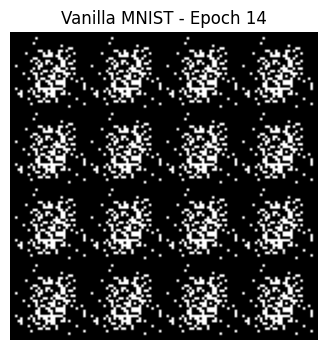

Epoch 16/30 | D Loss: 0.0000 | G Loss: 46.0081


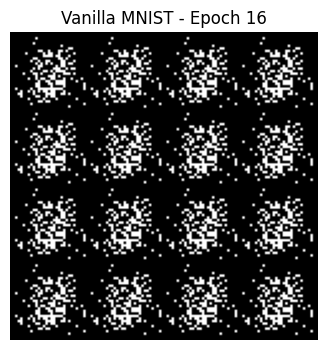

Epoch 18/30 | D Loss: 0.0000 | G Loss: 46.8702


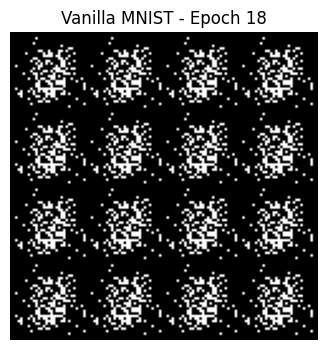

Epoch 20/30 | D Loss: 0.0000 | G Loss: 40.0533


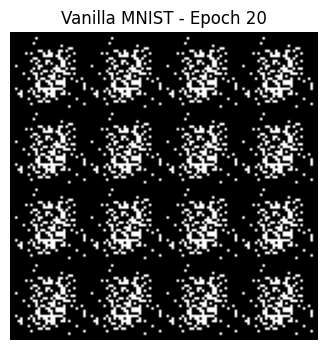

Epoch 22/30 | D Loss: 0.0000 | G Loss: 56.2321


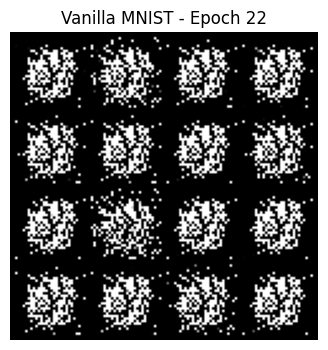

Epoch 24/30 | D Loss: 0.0000 | G Loss: 23.1706


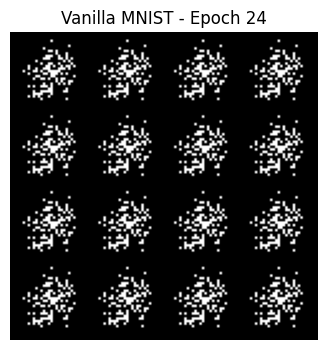

Epoch 26/30 | D Loss: 0.0000 | G Loss: 22.9436


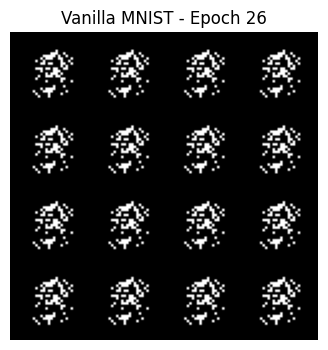

Epoch 28/30 | D Loss: 0.0000 | G Loss: 29.2683


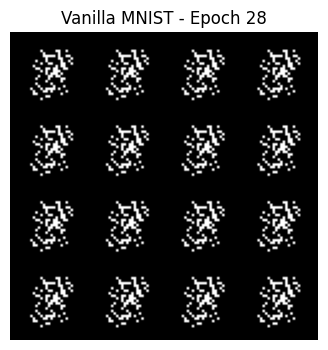

Epoch 30/30 | D Loss: 0.0000 | G Loss: 49.6615


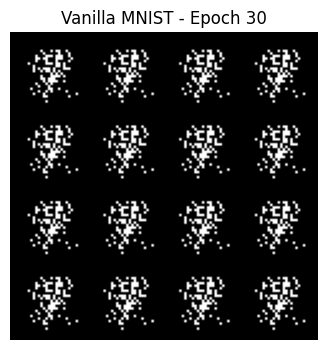

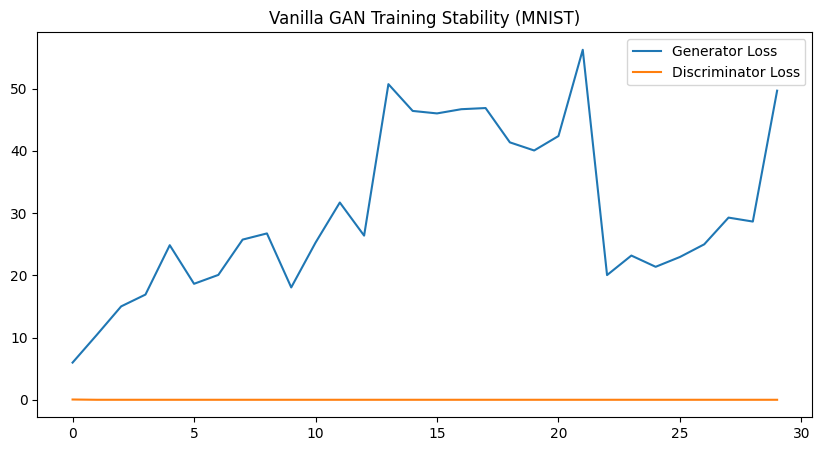


--- Training Vanilla GAN on FashionMNIST ---
Epoch 2/30 | D Loss: 1.1666 | G Loss: 2.4879


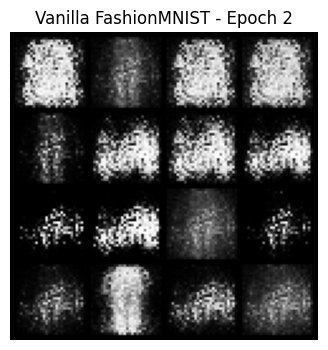

Epoch 4/30 | D Loss: 0.7747 | G Loss: 1.8974


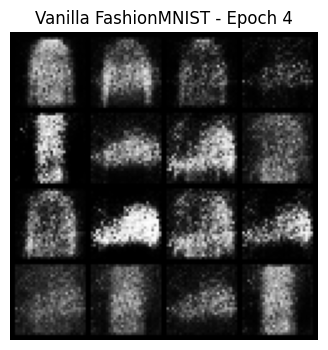

Epoch 6/30 | D Loss: 1.3137 | G Loss: 1.3587


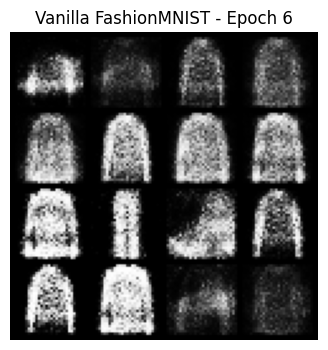

Epoch 8/30 | D Loss: 1.1334 | G Loss: 1.2897


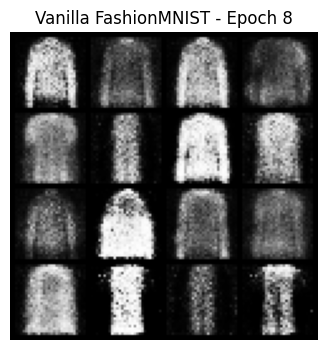

Epoch 10/30 | D Loss: 0.9753 | G Loss: 1.1270


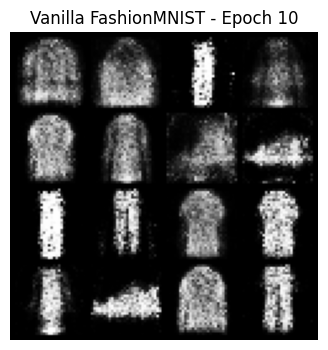

Epoch 12/30 | D Loss: 0.8947 | G Loss: 1.3309


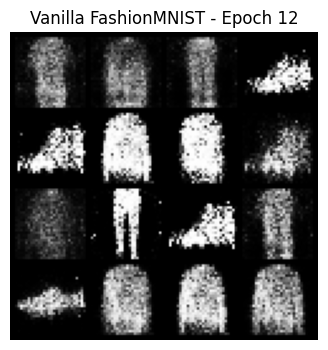

Epoch 14/30 | D Loss: 1.0103 | G Loss: 1.1898


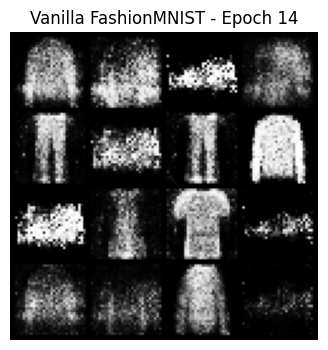

Epoch 16/30 | D Loss: 0.9771 | G Loss: 1.0973


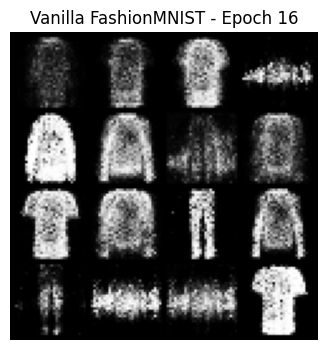

Epoch 18/30 | D Loss: 1.3146 | G Loss: 1.0710


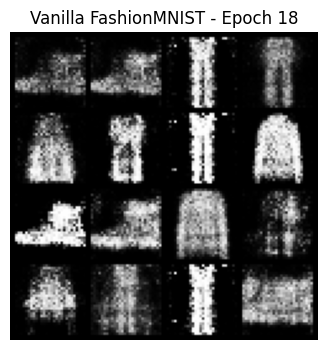

Epoch 20/30 | D Loss: 1.0216 | G Loss: 1.2621


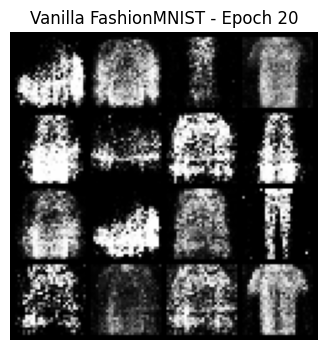

Epoch 22/30 | D Loss: 1.0744 | G Loss: 1.3110


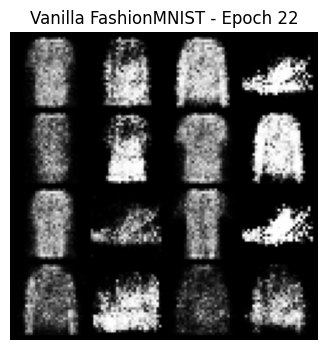

Epoch 24/30 | D Loss: 1.3162 | G Loss: 1.0067


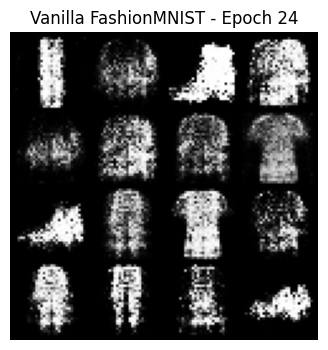

Epoch 26/30 | D Loss: 1.0290 | G Loss: 1.1388


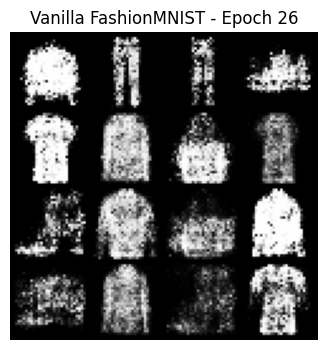

Epoch 28/30 | D Loss: 1.1344 | G Loss: 0.9614


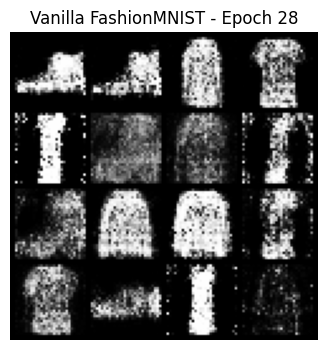

Epoch 30/30 | D Loss: 1.1989 | G Loss: 1.0176


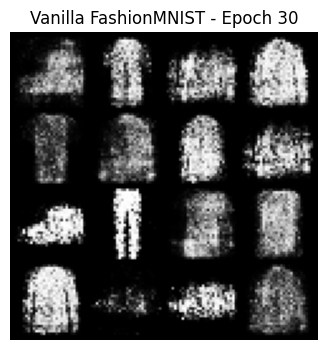

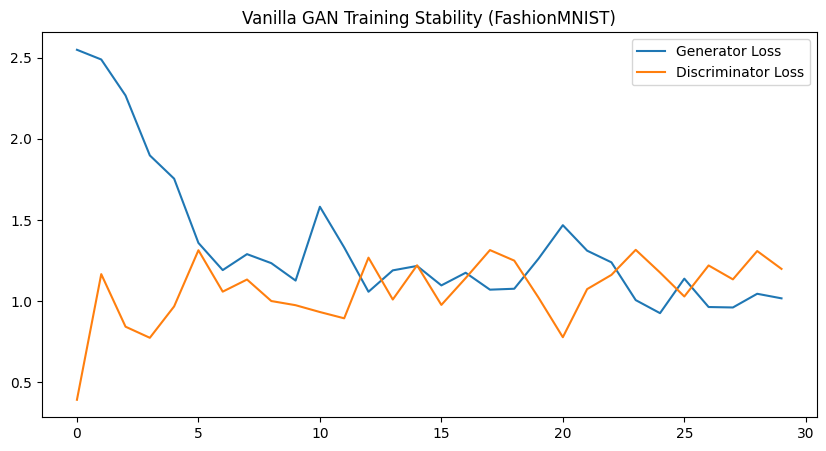


--- Training cGAN (FashionMNIST)  ---
Epoch 2 | D Loss: 1.4007 | G Loss: 2.3459


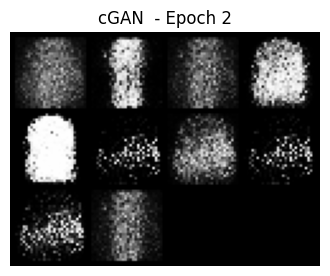

Epoch 4 | D Loss: 1.0043 | G Loss: 2.1590


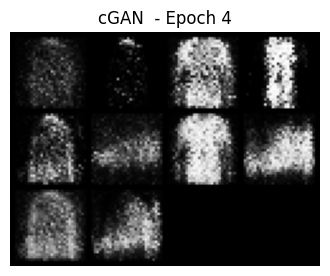

Epoch 6 | D Loss: 0.9956 | G Loss: 1.6797


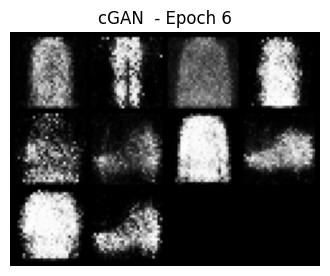

Epoch 8 | D Loss: 0.9956 | G Loss: 1.3807


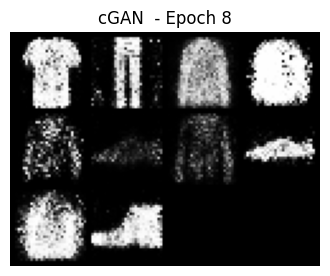

Epoch 10 | D Loss: 0.9543 | G Loss: 1.2676


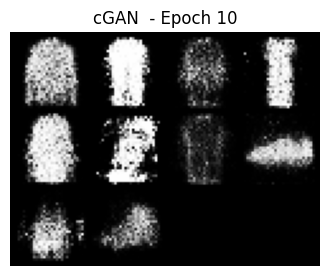

Epoch 12 | D Loss: 1.0920 | G Loss: 1.0547


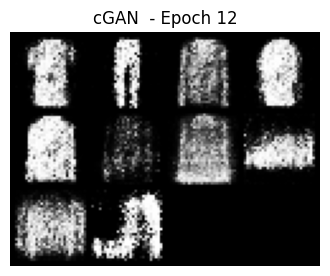

Epoch 14 | D Loss: 1.2966 | G Loss: 0.8952


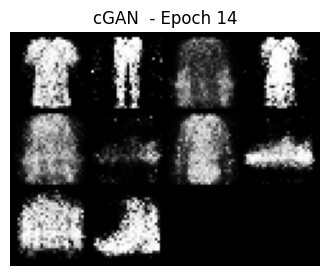

Epoch 16 | D Loss: 1.2545 | G Loss: 1.0416


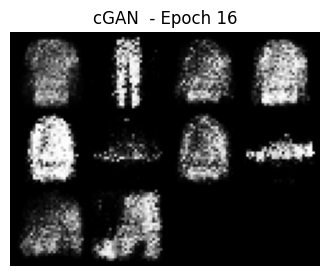

Epoch 18 | D Loss: 1.3518 | G Loss: 1.0042


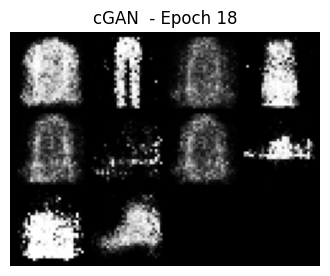

Epoch 20 | D Loss: 1.2572 | G Loss: 1.0061


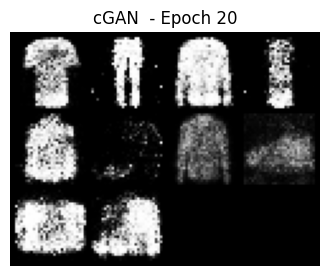

Epoch 22 | D Loss: 1.3018 | G Loss: 1.0180


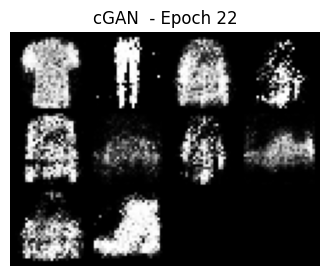

Epoch 24 | D Loss: 1.2661 | G Loss: 1.0729


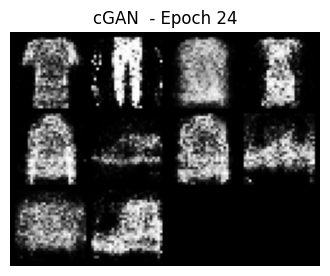

Epoch 26 | D Loss: 1.1135 | G Loss: 1.0416


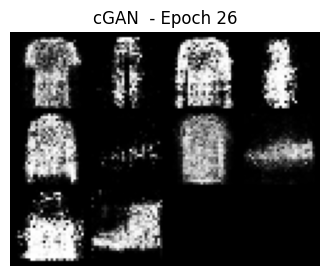

Epoch 28 | D Loss: 1.4672 | G Loss: 0.9017


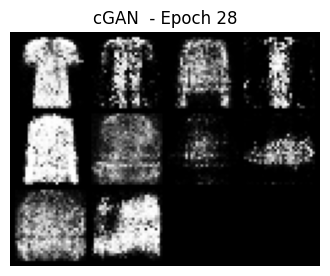

Epoch 30 | D Loss: 1.3316 | G Loss: 0.9056


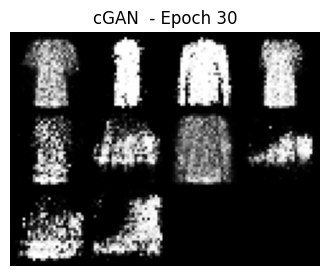


--- Training cGAN (FashionMNIST) + Feature Matching ---
Epoch 2 | D Loss: 0.8791 | G Loss: 11.5269


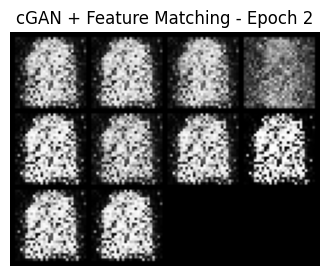

Epoch 4 | D Loss: 0.2291 | G Loss: 7.7953


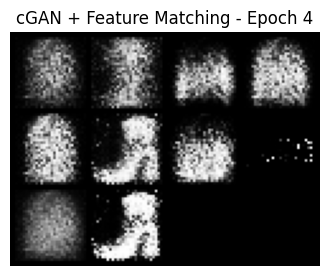

Epoch 6 | D Loss: 0.2008 | G Loss: 9.2510


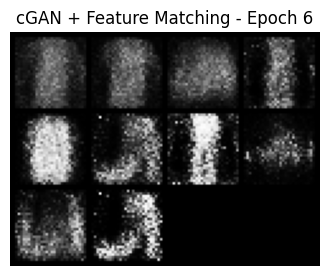

Epoch 8 | D Loss: 0.2332 | G Loss: 12.7148


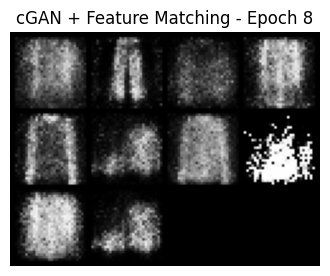

Epoch 10 | D Loss: 0.1925 | G Loss: 9.2325


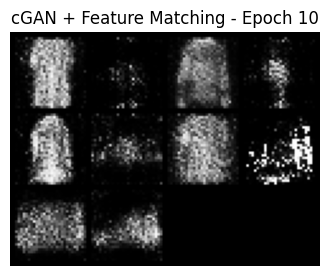

Epoch 12 | D Loss: 0.0251 | G Loss: 15.0810


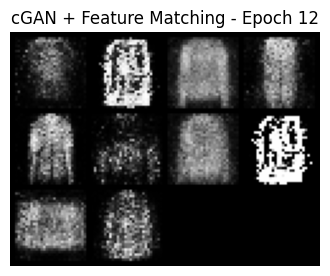

Epoch 14 | D Loss: 0.1300 | G Loss: 14.7439


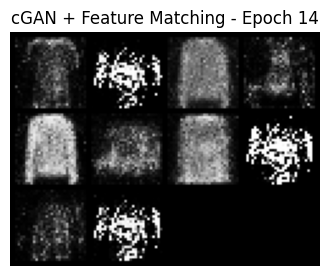

Epoch 16 | D Loss: 0.2069 | G Loss: 15.7088


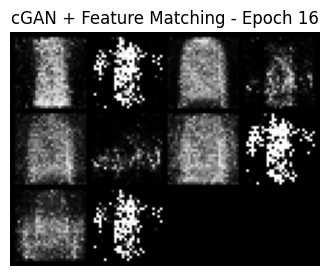

Epoch 18 | D Loss: 0.0184 | G Loss: 15.3531


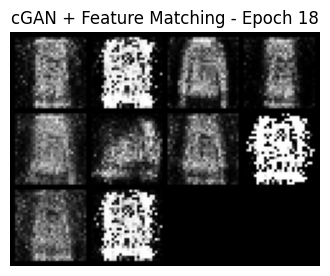

Epoch 20 | D Loss: 0.0557 | G Loss: 21.3151


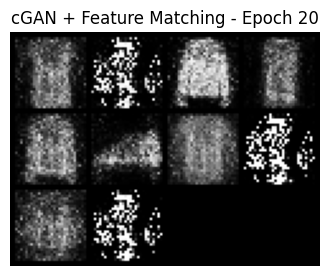

Epoch 22 | D Loss: 0.1543 | G Loss: 24.4758


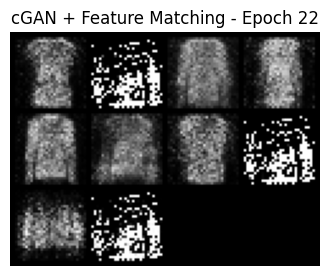

Epoch 24 | D Loss: 0.0028 | G Loss: 19.2417


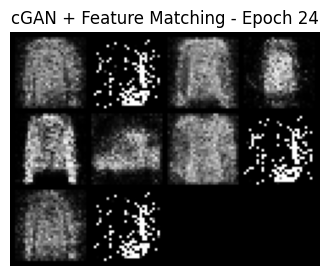

Epoch 26 | D Loss: 0.0357 | G Loss: 17.2766


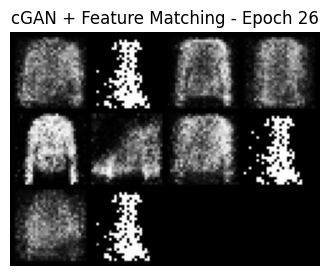

Epoch 28 | D Loss: 0.0222 | G Loss: 22.1344


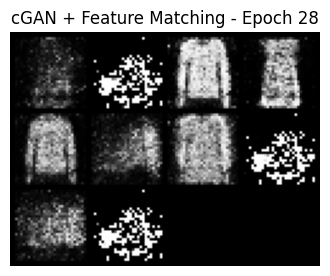

Epoch 30 | D Loss: 0.0020 | G Loss: 22.8618


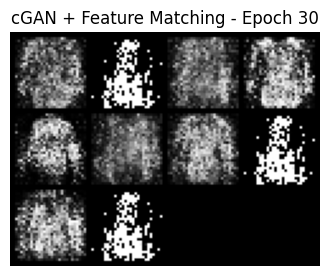


--- Training Progressive GAN (Simplified) on CIFAR-10 ---
ProGAN Epoch 1 | D Loss: 0.0011
ProGAN Epoch 2 | D Loss: 0.0001
ProGAN Epoch 3 | D Loss: 0.0000
ProGAN Epoch 4 | D Loss: 0.0000
ProGAN Epoch 5 | D Loss: 0.0000


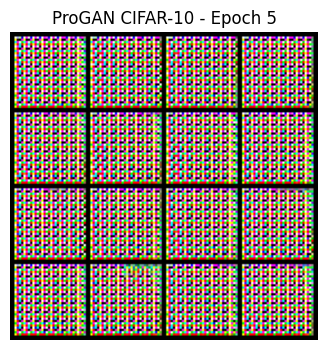

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
LR = 0.0002
Z_DIM = 100
EPOCHS_VANILLA = 30
EPOCHS_CGAN = 30
print(f"Using device: {DEVICE}")

# ==========================================
# 2. DATA LOADERS
# ==========================================
def get_dataloader(dataset_name, image_size=28):
    if dataset_name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3 channels
        ])
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        channels = 3
    else:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) # 1 channel
        ])
        if dataset_name == 'MNIST':
            dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        elif dataset_name == 'FashionMNIST':
            dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        channels = 1

    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True), channels

def visualize_samples(generator, epoch, z_dim=100, n_samples=16, c_labels=None, title="Generated"):
    generator.eval()
    z = torch.randn(n_samples, z_dim).to(DEVICE)
    with torch.no_grad():
        if c_labels is not None:
            fake_imgs = generator(z, c_labels)
        else:
            fake_imgs = generator(z)

    fake_imgs = (fake_imgs + 1) / 2 # Denormalize to [0, 1]
    fake_imgs = fake_imgs.cpu()

    grid = torchvision.utils.make_grid(fake_imgs, nrow=4, padding=2)
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.title(f"{title} - Epoch {epoch}")
    plt.show()
    generator.train()

# ==========================================
# 3. VANILLA GAN (Task 1)
# ==========================================
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, channels * 28 * 28),
            nn.Tanh() # Output -1 to 1
        )
        self.channels = channels

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), self.channels, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(channels * 28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

def train_vanilla_gan(dataset_name='MNIST'):
    print(f"\n--- Training Vanilla GAN on {dataset_name} ---")
    loader, channels = get_dataloader(dataset_name)

    G = Generator(Z_DIM, channels).to(DEVICE)
    D = Discriminator(channels).to(DEVICE)

    opt_G = optim.Adam(G.parameters(), lr=LR)
    opt_D = optim.Adam(D.parameters(), lr=LR)
    criterion = nn.BCELoss()

    g_losses, d_losses = [], []

    for epoch in range(EPOCHS_VANILLA):
        for real_imgs, _ in loader:
            real_imgs = real_imgs.to(DEVICE)
            batch_size = real_imgs.size(0)

            # Labels
            real_labels = torch.ones(batch_size, 1).to(DEVICE)
            fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

            # --- Train Discriminator ---
            opt_D.zero_grad()
            outputs = D(real_imgs)
            d_loss_real = criterion(outputs, real_labels)

            z = torch.randn(batch_size, Z_DIM).to(DEVICE)
            fake_imgs = G(z)
            outputs = D(fake_imgs.detach()) # Detach G to avoid training G here
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_D.step()

            # --- Train Generator ---
            opt_G.zero_grad()
            outputs = D(fake_imgs) # Re-compute D output for G update
            g_loss = criterion(outputs, real_labels) # Trick D into thinking they are real

            g_loss.backward()
            opt_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (epoch+1) % 2 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS_VANILLA} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
            visualize_samples(G, epoch+1, title=f"Vanilla {dataset_name}")

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.title(f"Vanilla GAN Training Stability ({dataset_name})")
    plt.legend()
    plt.show()

# ==========================================
# 4. CONDITIONAL GAN (cGAN) with Feature Matching (Task 2)
# ==========================================
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=100, n_classes=10, channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, 10)
        self.model = nn.Sequential(
            nn.Linear(z_dim + 10, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, channels * 28 * 28),
            nn.Tanh()
        )
        self.channels = channels

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        img = self.model(x)
        return img.view(img.size(0), self.channels, 28, 28)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes=10, channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, 10)

        # Feature extractor part (intermediate layers)
        self.fc1 = nn.Sequential(nn.Linear(channels * 28 * 28 + 10, 512), nn.LeakyReLU(0.2), nn.Dropout(0.3))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.LeakyReLU(0.2), nn.Dropout(0.3))
        # Final classifier
        self.fc3 = nn.Sequential(nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([img_flat, c], 1)

        feat1 = self.fc1(x)
        feat2 = self.fc2(feat1)
        out = self.fc3(feat2)
        return out, feat2 # Return intermediate features for Feature Matching

def train_cgan(feature_matching=False):
    title_suffix = "+ Feature Matching" if feature_matching else ""
    print(f"\n--- Training cGAN (FashionMNIST) {title_suffix} ---")

    loader, channels = get_dataloader('FashionMNIST')
    G = ConditionalGenerator(Z_DIM, 10, channels).to(DEVICE)
    D = ConditionalDiscriminator(10, channels).to(DEVICE)

    opt_G = optim.Adam(G.parameters(), lr=LR)
    opt_D = optim.Adam(D.parameters(), lr=LR)
    bce_criterion = nn.BCELoss()
    mse_criterion = nn.MSELoss() # For feature matching

    for epoch in range(EPOCHS_CGAN):
        for real_imgs, labels in loader:
            real_imgs, labels = real_imgs.to(DEVICE), labels.to(DEVICE)
            batch_size = real_imgs.size(0)
            real_target = torch.ones(batch_size, 1).to(DEVICE)
            fake_target = torch.zeros(batch_size, 1).to(DEVICE)

            # --- Train Discriminator ---
            opt_D.zero_grad()

            # Real
            d_out_real, _ = D(real_imgs, labels)
            d_loss_real = bce_criterion(d_out_real, real_target)

            # Fake
            z = torch.randn(batch_size, Z_DIM).to(DEVICE)
            gen_labels = torch.randint(0, 10, (batch_size,)).to(DEVICE)
            fake_imgs = G(z, gen_labels)

            d_out_fake, _ = D(fake_imgs.detach(), gen_labels)
            d_loss_fake = bce_criterion(d_out_fake, fake_target)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_D.step()

            # --- Train Generator ---
            opt_G.zero_grad()

            # If Feature Matching is ON:
            # G tries to minimize the difference between D's features for real vs fake images
            # Instead of just fooling D's final binary output.
            if feature_matching:
                _, real_feats = D(real_imgs, labels)
                _, fake_feats = D(fake_imgs, gen_labels) # Compute on G's output graph
                g_loss = mse_criterion(fake_feats, real_feats.detach())
            else:
                d_out_for_g, _ = D(fake_imgs, gen_labels)
                g_loss = bce_criterion(d_out_for_g, real_target)

            g_loss.backward()
            opt_G.step()

        if (epoch+1) % 2 == 0:
            print(f"Epoch {epoch+1} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
            # Generate one sample for each class 0-9
            eval_labels = torch.arange(10).to(DEVICE) # 0 to 9
            # repeat to fill batch if needed, or just generate 10
            z_eval = torch.randn(10, Z_DIM).to(DEVICE)
            visualize_samples(G, epoch+1, z_dim=Z_DIM, n_samples=10, c_labels=eval_labels, title=f"cGAN {title_suffix}")

# ==========================================
# 5. BONUS: SIMPLIFIED PROGRESSIVE GAN (Task 3)
# ==========================================
# A simplified implementation that trains on 16x16 then 32x32 for CIFAR10
# (Full ProGAN is too large for a single script, this demonstrates the concept)

class ProGenerator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        # Base: 4x4
        self.fc = nn.Linear(z_dim, 512 * 4 * 4)

        # Blocks
        self.conv_8 = nn.ConvTranspose2d(512, 256, 4, 2, 1) # 4->8
        self.conv_16 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 8->16
        self.conv_32 = nn.ConvTranspose2d(128, 3, 4, 2, 1) # 16->32 RGB

        # ToRGB layers for intermediate outputs
        self.torgb_8 = nn.Conv2d(256, 3, 1)
        self.torgb_16 = nn.Conv2d(128, 3, 1)

    def forward(self, z, level=2):
        # level 0: 8x8, level 1: 16x16, level 2: 32x32
        x = self.fc(z).view(-1, 512, 4, 4)
        x = F.leaky_relu(x, 0.2)

        # To 8x8
        x = self.conv_8(x)
        x = F.leaky_relu(x, 0.2)
        if level == 0: return torch.tanh(self.torgb_8(x))

        # To 16x16
        x = self.conv_16(x)
        x = F.leaky_relu(x, 0.2)
        if level == 1: return torch.tanh(self.torgb_16(x))

        # To 32x32
        x = self.conv_32(x)
        return torch.tanh(x)

def train_pro_gan():
    print("\n--- Training Progressive GAN (Simplified) on CIFAR-10 ---")
    # We will simulate growth: Train 16x16 for a bit, then 32x32
    # Note: Real ProGAN fades in layers. Here we just switch heads for simplicity.

    loader, channels = get_dataloader('CIFAR10', image_size=32)
    G = ProGenerator(Z_DIM).to(DEVICE)
    # Simple D for 32x32
    D = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2), # 16
        nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2), # 8
        nn.Conv2d(128, 256, 4, 2, 1), nn.LeakyReLU(0.2), # 4
        nn.Flatten(),
        nn.Linear(256*4*4, 1), nn.Sigmoid()
    ).to(DEVICE)

    opt_G = optim.Adam(G.parameters(), lr=0.0002)
    opt_D = optim.Adam(D.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # We only demonstrate training the final stage (32x32) for brevity in this assignment scope
    # using the full architecture
    epochs = 5
    for epoch in range(epochs):
        for real_imgs, _ in loader:
            real_imgs = real_imgs.to(DEVICE)
            batch = real_imgs.size(0)

            # Train D
            opt_D.zero_grad()
            real_out = D(real_imgs)
            loss_d_real = criterion(real_out, torch.ones(batch, 1).to(DEVICE))

            z = torch.randn(batch, Z_DIM).to(DEVICE)
            fake_imgs = G(z, level=2) # Generate 32x32
            fake_out = D(fake_imgs.detach())
            loss_d_fake = criterion(fake_out, torch.zeros(batch, 1).to(DEVICE))

            loss_d = loss_d_real + loss_d_fake
            loss_d.backward()
            opt_D.step()

            # Train G
            opt_G.zero_grad()
            fake_out = D(fake_imgs)
            loss_g = criterion(fake_out, torch.ones(batch, 1).to(DEVICE))
            loss_g.backward()
            opt_G.step()

        print(f"ProGAN Epoch {epoch+1} | D Loss: {loss_d.item():.4f}")

    visualize_samples(G, epochs, title="ProGAN CIFAR-10")


# ==========================================
# 6. EXECUTION
# ==========================================
if __name__ == "__main__":
    # Task 1: Vanilla GAN
    train_vanilla_gan('MNIST')
    train_vanilla_gan('FashionMNIST')

    # Task 2: Conditional GAN + Advanced Feature Matching
    train_cgan(feature_matching=False) # Standard cGAN
    train_cgan(feature_matching=True)  # Advanced cGAN with Feature Matching

    # Task 3: Progressive GAN (Bonus)
    train_pro_gan()